# Running Machine Learning tasks with DAT (Deployable Analysis environmenT) 

Problem at hand:
Train a Machine Learning model on sparse data. Use the model to predict one target variable as map in space and time. 

![data](./figs/small.jpg)

This notebook shows a simple workflow to:

- train a RandomForest model 
- Preprocess data
- Run the model 

This notebook and data are based on the research carried by Qianqian Han https://doi.org/10.5194/egusphere-egu24-5488


## Model training

In [9]:
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

import joblib

In [10]:
import sys
sys.path.append('.')
from utils import training_testing_preprocess, igbp_to_landcover

In [11]:
parent_in_path = "/scratch/EcoExtreML"
parent_out_path = "/scratch/outputs"
data_paths = {"input_data": f"{parent_in_path}/model/training_testing_2014.csv",
            "igbp_table": f"{parent_in_path}/auxiliary/lccs_to_igbp_table.csv",
            "igbp_class": f"{parent_in_path}/auxiliary/IGBP11unique.csv",
             }
              
input_vars = ['Rin', 'Rli', 'p', 'Ta', 'ea', 'u', 'CO2', 'LAI','Vcmo', 'hc', 'Precip_msr','SSM', 'IGBP_veg_long', 
              'Rntot', 'LEtot', 'Htot','Gtot', 'Actot', 'SIF685', 'SIF740']

In [12]:
# read data
input_df = pd.read_csv(data_paths["input_data"], usecols=input_vars)

# define one hot encoding 
encoder = OneHotEncoder(sparse_output=False)

# preprocess data
input_df = training_testing_preprocess(input_df)
igbp_class = pd.read_csv(data_paths["igbp_class"])['0'].unique()
input_df = igbp_to_landcover(input_df, encoder, igbp_class)

In [13]:
# training 1 output
x_vars = ['Rin', 'Rli', 'p', 'Ta', 'ea', 'u', 'CO2', 'LAI','Vcmo', 'hc', 'Precip_msr','SSM', *[f'IGBP_veg_long{i}' for i in range(1, 12)]]
x = input_df[x_vars]

y_vars = ['LEtot']
y = input_df[y_vars].values.ravel()

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=0, shuffle=True)
regressor = RandomForestRegressor(n_estimators=10,
                          max_depth=20,
                          random_state=0,
                          n_jobs=1,
                          min_samples_split=10,
                          min_samples_leaf=4)

regressor.fit(x_train, y_train)
regressor

RandomForestRegressor(max_depth=20, min_samples_leaf=4, min_samples_split=10,
                      n_estimators=10, n_jobs=1, random_state=0)

In [14]:
joblib.dump(regressor, f"{parent_out_path}/model_LEtot.joblib")
print("model is saved")

model is saved


## Preparing data

In [7]:
import dcachefs
import fsspec
import xarray as xr
import rioxarray

In [8]:
import sys
sys.path.append('.')
from utils import fix_coords, fix_time

In [21]:
parent_in_path = f"dcache://pnfs/grid.sara.nl/data/remotesensing/disk/EcoExtreML/raw_eu"

data_paths = {"era5land": f"{parent_in_path}/era5land/*_EU.nc",
            "lai": f"{parent_in_path}/lai_v2/*_EU.nc",
            "ssm": f"{parent_in_path}/ssm/GlobalGSSM11km2014_20240214.tif_EU.tif",
            "co2": f"{parent_in_path}/co2/CAMS_CO2_2003-2020.nc_EU.nc",
            "landcover": f"{parent_in_path}/igbp/landcover10km_EU.nc",
            "vcmax": f"{parent_in_path}/vcmax/TROPOMI_Vmax_Tg_mean10km_EU.nc",
            "canopyheight": f"{parent_in_path}/canopy_height/canopy_height_11kmEurope20230921_10km_EU.nc",
            }

parent_out_path = "/scratch/outputs"

# region of interest here NL
bbox = [3.315, 50.8037,7.0921, 53.5104]

# time series
start_time = "2014-1-31"
end_time = "2014-02-05"

In [21]:
def open_files(paths):
    ofs = fsspec.open_files(paths, block_size=5*2**20)
    return [of.open() for of in ofs]

In [22]:
%%time
for data_path in data_paths:
    ofs = open_files(data_paths[data_path])
    # read data
    if data_path == "era5land":
        ds = xr.open_mfdataset(ofs, engine="h5netcdf")
    
    elif data_path == "co2":
        ds = xr.open_mfdataset(ofs, engine="h5netcdf")
        
    elif data_path == "ssm":  # this is a tif data
        ds = rioxarray.open_rasterio(ofs[0])
        ds = fix_coords(ds.to_dataset(name="ssm"))

    else:
        ds = xr.open_mfdataset(ofs, engine="h5netcdf", decode_times=False)
        ds = fix_coords(ds)
        
    # convert day of year
    ds = fix_time(ds, start_time)

    masked_ds = ds.sel(longitude=slice(bbox[0], bbox[2]), latitude=slice(bbox[1], bbox[3]), time=slice(start_time, end_time))
    
    # save data 
    out_path = f"{parent_out_path}/{data_path}_{start_time}_{end_time}_NL.nc"
    masked_ds.to_netcdf(out_path, mode='w')
    print(f"{out_path} is saved")
    print("=======================================")

/scratch-shared/falidoost/NL/era5land_2014-1-31_2014-02-05_NL.nc is saved


/gpfs/home4/falidoost/mamba/envs/emulator/lib/python3.9/site-packages/dask/array/core.py:1702: RuntimeWarning: invalid value encountered in cast
  x = x.astype(dtype)
/gpfs/home4/falidoost/mamba/envs/emulator/lib/python3.9/site-packages/dask/array/core.py:1702: RuntimeWarning: invalid value encountered in cast
  x = x.astype(dtype)


/scratch-shared/falidoost/NL/lai_2014-1-31_2014-02-05_NL.nc is saved
/scratch-shared/falidoost/NL/ssm_2014-1-31_2014-02-05_NL.nc is saved
/scratch-shared/falidoost/NL/co2_2014-1-31_2014-02-05_NL.nc is saved
/scratch-shared/falidoost/NL/landcover_2014-1-31_2014-02-05_NL.nc is saved
/scratch-shared/falidoost/NL/vcmax_2014-1-31_2014-02-05_NL.nc is saved
/scratch-shared/falidoost/NL/canopyheight_2014-1-31_2014-02-05_NL.nc is saved
CPU times: user 5.44 s, sys: 1.57 s, total: 7.01 s
Wall time: 1min 4s


## Interpolations and Variable derivation
#### Skip running during the presentation

In [ ]:
import xarray as xr
import numpy as np
import pandas as pd
from PyStemmusScope import variable_conversion as vc
import sys
sys.path.append('.')
from utils import interpolation, era5land_accumulated_vars, map_landcover_to_igbp, landcover_to_igbp
from sklearn.preprocessing import OneHotEncoder

start_time = "2014-1-31"
end_time = "2014-02-05"

parent_in_path = "./data"
data_paths = {"era5land": f"{parent_in_path}/NL/era5land_{start_time}_{end_time}_NL.nc",
              "lai": f"{parent_in_path}/NL/lai_{start_time}_{end_time}_NL.nc",
              "ssm": f"{parent_in_path}/NL/ssm_{start_time}_{end_time}_NL.nc",
              "co2": f"{parent_in_path}/NL/co2_{start_time}_{end_time}_NL.nc",
              "landcover": f"{parent_in_path}/NL/landcover_{start_time}_{end_time}_NL.nc",
              "vcmax": f"{parent_in_path}/NL/vcmax_{start_time}_{end_time}_NL.nc",
              "canopyheight": f"{parent_in_path}/NL/canopyheight_{start_time}_{end_time}_NL.nc",
              "all_data": f"{parent_in_path}/NL/all_data_{start_time}_{end_time}_NL.nc",
              "igbp_table": f"{parent_in_path}/auxiliary/lccs_to_igbp_table.csv",
              "igbp_class": f"{parent_in_path}/auxiliary/IGBP11unique.csv",
            }
parent_out_path = "./data"

variable_names = {"lai": "LAI",
                  "ssm": "band_data",
                  "co2": "co2",
                  "canopyheight": "__xarray_dataarray_variable__",
                  "vcmax": "__xarray_dataarray_variable__",
                  "landcover": "lccs_class"}  

# interpolation
era5land = xr.open_dataset(data_paths["era5land"])
other_coords = {"time": era5land.time, "longitude": era5land.longitude, "latitude": era5land.latitude}

for name in variable_names:
    ds = xr.open_dataset(data_paths[name])
    ds_interpolated = interpolation(ds, other_coords)    
    era5land[name] = ds_interpolated[variable_names[name]]

# save
out_path = f"{parent_out_path}/NL/all_data_{start_time}_{end_time}_NL.nc"
era5land.to_netcdf(out_path, mode='w')
print(f"{out_path} is saved")

# variable derivation
# read data
all_data = xr.open_dataset(data_paths["all_data"])

# variable calculations
all_data = era5land_accumulated_vars(all_data, "ssrd", "Rin", 3600)
all_data = era5land_accumulated_vars(all_data, "strd", "Rli", 3600)
all_data = era5land_accumulated_vars(all_data, "tp", "Precip_msr", 0.001) # to mm
all_data["p"] = all_data["sp"] / 100  # Pa -> hPa
all_data["Ta"] = all_data["t2m"] - 273.15  # K -> degC
all_data["ea"] = vc.calculate_es(all_data["d2m"] - 273.15)*10 # *10 is for kPa -> hPa
all_data["u"] = (all_data["u10"] ** 2 + all_data["v10"] ** 2) ** 0.5
all_data["ssm"] = all_data["ssm"] / 1000

# convert landcover to IGBP
# lookup tables
igbp_table = pd.read_csv(data_paths["igbp_table"])
igbp_class = pd.read_csv(data_paths["igbp_class"])['0'].unique()

# define one hot encoding for IGBP using dask-ml functions
encoder = OneHotEncoder(sparse_output=False)

# Unsorted categories are not yet supported by dask-ml
igbp_stemmus_scope = np.sort(igbp_table["IGBP_STEMMUS_SCOPE"].to_numpy().reshape(-1,1))
encoder = encoder.fit(igbp_stemmus_scope)  
lookup_table = igbp_table.set_index("lccs_class").T.to_dict('records')[0]

ds = landcover_to_igbp(all_data, "landcover", encoder, lookup_table, igbp_class)

# rename some variables
rename_vars = {"co2": "CO2", "lai": "LAI", "canopyheight": "hc", "ssm": "SSM", "vcmax": "Vcmo"}
ds = ds.rename(rename_vars)

# save
out_path = f"{parent_out_path}/NL/model_input_{start_time}_{end_time}_NL.nc"
ds.to_netcdf(out_path, mode='w')
print(f"{out_path} is saved")

## Model prediction

In [1]:
import xarray as xr
import numpy as np

from joblib import load

In [3]:
import sys
sys.path.append('.')
from utils import arr_to_ds

In [4]:
start_time = "2014-1-31"
end_time = "2014-02-05"

parent_in_path = "/scratch/EcoExtreML"
parent_out_path = "/scratch/outputs"

model_input = xr.open_dataset(f"{parent_in_path}/NL/model_input_{start_time}_{end_time}_NL.nc")

In [5]:
# load model
path_model = f"{parent_in_path}/model/model_LEtot.joblib"
model = load(path_model)
model

RandomForestRegressor(max_depth=20, min_samples_leaf=4, min_samples_split=10,
                      n_estimators=10, n_jobs=1, random_state=0)

In [6]:
input_vars = [
    'Rin', 'Rli', 'p', 'Ta', 'ea', 'u', 'CO2', 'LAI', 'Vcmo','hc', 'Precip_msr',  
    'SSM',  *[f'IGBP_veg_long{i}' for i in range(1, 12)]
]

# select input/output data 
input_ds = model_input[input_vars]
output_vars = ['LEtot']

In [7]:
df_features = input_ds.to_dataframe().reset_index().drop(columns=["time", "longitude", "latitude"])

# Convert the nan value as 0 for the calculation
df_features = df_features.fillna(0)

LEH = model.predict(df_features)

output_ds = arr_to_ds(LEH, input_ds, output_vars)

# save data
out_path = f"{parent_out_path}/predicted_{start_time}_{end_time}_NL.nc"
output_ds.to_netcdf(out_path, mode='w')
print(f"{out_path} is saved")

/scratch-shared/falidoost/predicted_2014-1-31_2014-02-05_NL.nc is saved
CPU times: user 279 ms, sys: 43.4 ms, total: 322 ms
Wall time: 327 ms


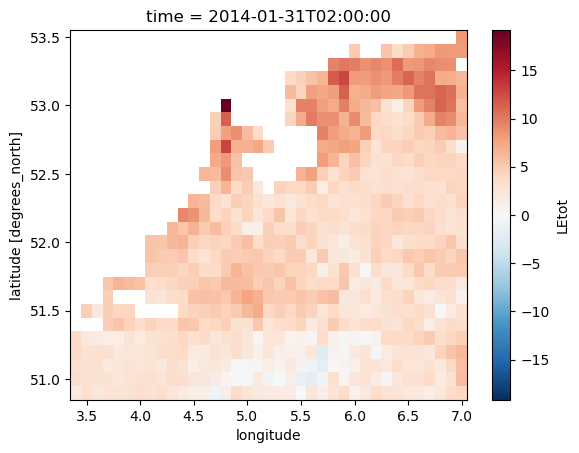

In [8]:
output_ds.LEtot.isel(time=2).plot()